# Sumário
1. Inicialização
    * Importando Bibliotecas
    * Variáveis Globais
    * Funções
2. Carregando o Conjunto de Dados no Pandas
3. Pré-Processamento e Análise
    * Seleção do Estado a ser estudado
    * Plojeção do comportamento da variável alvo
    * Realização do teste de estacionariedade na série original
    * Plojeção do comportamento da variável alvo com média móvel
    * Realização da decomposição da série em tendência, sazonalidade e resíduos
    * Exibição do gráfico de sazonalidade da série
    * Exibição do gráfico de diferenciações, autocorrelações e autocorrelações parciais da série original e de suas diferenciações de 1ª e 2ª ordem
    * Realização da diferenciação de primeira ordem e o teste de estacionariedade na série diferenciada
    * Realização da autocorreação por número de meses
4. Machine Learning
    * Divisão da base em treino e teste
    * Execução do auto arima
        * Predição e validação do melhor modelo considerado pelo AIC
        * Ilustração do gráfico do comportamento real x predito
        * Ilustração do gráfico do comportamento anual do real x predito
        * Ilustração do gráfico do comportamento da série real x predito
    * Execução do sarimax
        * Predição e validação do modelo considerado
        * Ilustração do gráfico do comportamento real x predito
        * Ilustração do gráfico do comportamento anual do real x predito
        * Ilustração do gráfico do comportamento da série real x predito
    * Execução do sarimax a partir dos parâmetros fornecidos pelo auto arima
        * Predição e validação do modelo considerado
        * Ilustração do gráfico do comportamento real x predito
        * Ilustração do gráfico do comportamento anual do real x predito
        * Ilustração do gráfico do comportamento da série real x predito

# Inicialização
* Importando Bibliotecas
* Variáveis Globais

## Importando Bibliotecas

In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt

## viz
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## model
import statsmodels.api as sm
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates

%matplotlib inline

# Variáveis Globais

In [2]:
# Coloque aqui o caminho ao qual o arquivo se encontra
PATH = '../Dados/Armarios/Bases/'

# Coloque aqui o nome do arquivo
file_train = 'base_nordeste_V2.csv'

# Funções

## Seleção do estado a ser analisado

In [3]:
def uf_selection(uf, dataset, target, pattern):
    """ Create the dataframe based in the state wants to predict.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            uf (string): The state under analysis.

        Returns:
            A dataframe with the state under analysis.
    """   
    dataset.columns = dataset.columns.str.replace(pattern, '')
    dataset['mes'] = dataset['mes'].astype('string')
    dataset['mes'] = dataset['mes'].apply(lambda x: pd.to_datetime(str(x) + '01'))
    dataset = dataset[['mes', target]].loc[dataset['uf'] == uf]
    
    return dataset

## Teste de estacionalidade de Dickey Fuller

In [4]:
def adf_test(dataset):
    """ Performs Augmented Dickey Fuller test.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.

        Returns:
            The results of adf test.
    """   
    
    print('Resultado do Teste Dickey-Fuller:')
    dftest = adfuller(dataset, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', '# de lags', '# de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valores Críticos ({})'.format(key)] = value
   
    print(dfoutput)

## Diferenciação da série e teste de estacionariedade na série diferenciada

In [5]:
def serie_differentiation(dataset, target):
    """ Create serie's differentiation.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            
        Returns:
            A plot with serie's differentiation, the results of adf test in the new serie and differentiation data.
    """     
     
    plt.figure(figsize=(15, 5))
    df_diff = np.diff(dataset[target])
    plt.plot(df_diff)

    print(adf_test(df_diff))
    
    return df_diff

## Autocorrelação Mensal

In [6]:
def autocorrelation_lag(dataset, target):
    """ Print autocorrelation based in 1, 3, 6, 9 and 12 months.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            
        Returns:
            The autocorrelation based in 1, 3, 6, 9 and 12 months.
    """     
     
    autocorrelation_lag1 = dataset[target].autocorr(lag=1)
    print("Um mês: ", autocorrelation_lag1)

    autocorrelation_lag3 = dataset[target].autocorr(lag=3)
    print("Três meses: ", autocorrelation_lag3)

    autocorrelation_lag6 = dataset[target].autocorr(lag=6)
    print("Seis meses: ", autocorrelation_lag6)

    autocorrelation_lag9 = dataset[target].autocorr(lag=9)
    print("Nove meses: ", autocorrelation_lag9)

    autocorrelation_lag12 = dataset[target].autocorr(lag=12)
    print("Doze meses: ", autocorrelation_lag12)

## Pré-processamento e Divisão entre Treino e Teste

In [7]:
def train_test_split_data(dataset, target, start, period, frequency, date_split, date_end, normalization):
    """ Pre processing and split the train and test data.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            start (string): The start date to be fill with NaNs to be predict.
            period (int): The number of months to be fill with NaNs to be predict.
            frequency (string): The unit to by fill, i.e., 'M' for months.
            date_split (datetime): The date used for threshold to split the train and test.
            date_end (datetime): The end date used for test dataset.
            normalization (boolean): True if normalization will used and False if not.
            
        Returns:
            The dataset pre processed, start and end intervals, and train and test datasets.
    """     
     
    temp = pd.DataFrame(pd.date_range(start=start, periods=period, freq=frequency), columns=['mes'])
    temp['mes'] = pd.to_datetime(temp['mes'].dt.strftime('%Y-%m-01'))
    temp[target] = np.nan

    df = pd.concat([dataset, temp]).reset_index(drop=True)
    del temp

    xtrain = df[df['mes'] < date_split]
    xtest = df.loc[(df['mes'] >= date_split) & (df['mes'] <= date_end)]

    if(normalization == True):
        x_train_scaled = xtrain.copy()
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler_data = scaler.fit_transform(x_train_scaled[target].values.reshape(-1, 1))
        x_train_scaled[target] = scaler_data
    
        xtrain = x_train_scaled.copy()
    
    print('Train interval: ', xtrain['mes'].min().date(), ' até ', xtrain['mes'].max().date())
    print('Test interval: ', xtest['mes'].min().date(), ' até ', xtest['mes'].max().date())

    interval_start = xtest.index.min()
    interval_end = xtest.index.max()

    print('Test interval: ', interval_start, ' até ', interval_end)

    xtrain.set_index('mes', inplace = True)
    xtest.set_index('mes', inplace = True)
    
    return xtrain, xtest, interval_start, interval_end, df

## Arima Automático

In [8]:
def automatic_arima(train_dataset, start_p, start_q, max_p, max_q, m, start_P, seasonal, d, D, trace, n_jobs, stepwise = False,
                    test = 'adf', error_action='ignore', suppress_warnings=True, normalization = False, target = ''):
    """ Execute automatic arima models.

        Args:
        train_dataset (array-like or iterable, shape=(n_samples,)): The time-series to which to fit the ARIMA estimator. This may either be a Pandas Series object (statsmodels can internally use the dates in the index), or a numpy array. This should be a one-dimensional array of floats, and should not contain any np.nan or np.inf values. 
        start_p (int): The starting value of p, the order (or number of time lags) of the auto-regressive (“AR”) model. Must be a positive integer.
        start_q (int): The starting value of q, the order of the moving-average (“MA”) model. Must be a positive integer.
        max_p (int): The maximum value of p, inclusive. Must be a positive integer greater than or equal to start_p.
        max_q (int): The maximum value of q, inclusive. Must be a positive integer greater than start_q.
        start_P (int): The starting value of P, the order of the auto-regressive portion of the seasonal model.
        seasonal (boolean): Whether to fit a seasonal ARIMA. Default is True. Note that if seasonal is True and m == 1, seasonal will be set to False.
        d (int): The order of first-differencing. If None (by default), the value will automatically be selected based on the results of the test (i.e., either the Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or the Phillips–Perron test will be conducted to find the most probable value). Must be a positive integer or None. Note that if d is None, the runtime could be significantly longer.
        D (int): The order of the seasonal differencing. If None (by default, the value will automatically be selected based on the results of the seasonal_test. Must be a positive integer or None.
        trace (boolean): Whether to print status on the fits. A value of False will print no debugging information. A value of True will print some. Integer values exceeding 1 will print increasing amounts of debug information at each fit.
        n_jobs (int) (default=1): The number of models to fit in parallel in the case of a grid search (stepwise=False). Default is 1, but -1 can be used to designate “as many as possible”.
        stepwise (boolean): Whether to use the stepwise algorithm outlined in Hyndman and Khandakar (2008) to identify the optimal model parameters. The stepwise algorithm can be significantly faster than fitting all (or a random subset of) hyper-parameter combinations and is less likely to over-fit the model.
        test (string) (default=’kpss’) Type of unit root test to use in order to detect stationarity if stationary is False and d is None. Default is ‘kpss’ (Kwiatkowski–Phillips–Schmidt–Shin).
        error_action (string) (default=’warn’): If unable to fit an ARIMA for whatever reason, this controls the error-handling behavior. Model fits can fail for linear algebra errors, convergence errors, or any number of problems related to stationarity or input data.
            - ‘warn’: Warns when an error is encountered (default)
            - ‘raise’: Raises when an error is encountered
            - ‘ignore’: Ignores errors (not recommended)
            - ‘trace’: Logs the entire error stacktrace and continues the search. This is the best option when trying to determine why a model is failing.
        suppress_warnings (boolean): Many warnings might be thrown inside of statsmodels. If suppress_warnings is True, all of the warnings coming from ARIMA will be squelched. Note that this will not suppress UserWarnings created by bad argument combinations.

        Returns:
            The trained model.
    """     
    if(normalization == True):
        x_train_scaled = train_dataset.copy()
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler_data = scaler.fit_transform(x_train_scaled[target].values.reshape(-1, 1))
        x_train_scaled[target] = scaler_data
        train_dataset = x_train_scaled.copy()
        
    stepwise_model = auto_arima(train_dataset, start_p=start_p, start_q=start_q, max_p=max_p, max_q=max_q, m=m, start_P=start_P, seasonal=seasonal, d=d, D=D, trace=trace, error_action=error_action,
                            suppress_warnings=suppress_warnings, stepwise=stepwise, n_jobs = n_jobs)
    
    summary = stepwise_model.summary()
    print('AIC:' + str(stepwise_model.aic()))
    stepwise_model.fit(train_dataset)
    
    return stepwise_model, summary

## Algoritmo Sarimax

In [9]:
def sarimax_algorithm(train_dataset, test_dataset, target, interval_start, interval_end, order, seasonal_order, normalization):
    """ Execute sarimax algorithm.

        Args:
        train_dataset (array-like or iterable, shape=(n_samples,)): The time-series to which to fit the sarimax estimator.
        test_dataset (object/spreadsheet): The test dataset under analysis.
        target (string): The name of target column under analysis.
        interval_start (int): The start index of the test interval.
        interval_end (int): The end index of the test interval.
        order (tuple): The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
        seasonal_order (tuple): The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.
        normalization (boolean): True if normalization will used and False if not.
        
        Returns:
            The trained model and the predictions.
    """     
    if(normalization == True):
        x_train_scaled = train_dataset.copy()
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler_data = scaler.fit_transform(x_train_scaled[target].values.reshape(-1, 1))
        x_train_scaled[target] = scaler_data
        xtrain = x_train_scaled.copy()
        
    sarimax = sm.tsa.statespace.SARIMAX(xtrain, order=order, seasonal_order=seasonal_order).fit()
    
    test_dataset['pred'] = sarimax.predict(start=interval_start, end=interval_end, dynamic=True)
    scaler_data = scaler.inverse_transform(test_dataset['pred'].values.reshape(-1, 1))
    test_dataset['pred'] = scaler_data
    
    return sarimax, test_dataset

## Métricas de Validação do Modelo

In [10]:
def validation_metrics(y_true, y_pred):
    """ Performs the model's validation metrics (Mean Absolute Percentage Error & Root Mean Square Error & Mean Absolute Error).

        Args:
            y_true (object/spreadsheet): The dataset under analysis.
            y_pred (object/spreadsheet): The dataset under analysis.

        Returns:
            The results of adf test.
    """   
    
    _mape = np.mean(np.abs((y_true - y_pred) / y_true )) * 100
    _rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    _mae = np.mean(np.abs(y_pred - y_true))

    print('MAPE: {:.2f}, RMSE: {:.2f}, MAE: {:.2f}'.format(_mape, _rmse, _mae))

## Gráfico com comportamento da variável a ser predita

In [11]:
def plot_target_behavior(dataset, target):
    """ Create the plot based in the target variable that wants to predict.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.

        Returns:
            A plot with target behavior.
    """  
    fig = plt.figure(figsize=(15,8))

    sns.lineplot(data=dataset, x=dataset['mes'].dt.strftime('%Y%m'), y=target)
    plt.xticks(rotation=90)
    plt.ylabel('Consumo Total')
    
    plt.show()

## Gráfico com comportamento da variável a ser predita, da média móvel e do desvio padrão móvel

In [12]:
def plot_moving_average(dataset, target, window):
    """ Create the plot based in the target's moving average.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            window (int): The moving average window.

        Returns:
            A plot with target behavior, target's moving average and its moving standard deviation.
    """     
    fig = plt.figure(figsize=(20, 6))

    x = dataset['mes']
    y = dataset[target]
    
    mm3 = dataset[target].rolling(window).mean()
    rolling_std = dataset[target].rolling(window).std()
    
    plt.plot(x, y, label='Real', color='#3CADF2')
    plt.plot(x, mm3, label='Média Móvel de ' + str(window), color='red')
    plt.plot(x, rolling_std, label='Std de ' + str(window), color='green')


    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gcf().autofmt_xdate()

## Gráficos de decomposição da série

In [13]:
def serie_decompose(dataset, target):
    """ Create the plots based in serie decomposition into trend, sazonality and residues.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            
        Returns:
            A plot with serie's decompose and the decompose data.
    """     
    
    decompose = dataset.copy()
    decompose.set_index("mes", inplace=True)
    decompose_data = seasonal_decompose(decompose[target], model="multiplicative")
    fig = decompose_data.plot()
    fig.set_size_inches((12, 12))
    
    return decompose_data

## Gráfico com sazonalidade da série

In [14]:
def plot_seasonality(decompose_data):
    """ Create the seasonality's plot.

        Args:
            decompose_data (statsmodels object): The decompose data generated by serie_decompose function.
            
        Returns:
            A plot with serie's seasonality and the seasonality data.
    """     
     
    seasonality = decompose_data.seasonal
    fig = seasonality.plot(color='green')
    fig.figure.set_size_inches((20, 5))
    
    return seasonality

## Gráficos de diferenciação, autocorrelação (acf) e autocorrelação parcial (pacf) 

In [15]:
def plot_diff_acp_pacf(dataset, target):
    """ Create differentiation, autocorrelation and parcial autocorrelation plot.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The name of target column under analysis.
            
        Returns:
            A plot with differentiation, autocorrelation and parcial autocorrelation plot.
    """     
    
    fig, axes = plt.subplots(3, 3, figsize=(15,15))

    # Original Series
    axes[0, 0].plot(dataset[target]); axes[0, 0].set_title('Original Series')
    fig = sm.graphics.tsa.plot_acf(dataset[target], lags=40, ax=axes[0,1])
    fig = sm.graphics.tsa.plot_pacf(dataset[target], lags=20, ax=axes[0,2])

    # 1st Order Differencing Series
    axes[1, 0].plot(dataset[target].diff()); axes[1, 0].set_title('1st Order Differencing')
    fig = sm.graphics.tsa.plot_acf(dataset[target].diff().dropna(), lags=40, ax=axes[1,1])
    fig = sm.graphics.tsa.plot_pacf(dataset[target].diff().dropna(), lags=20, ax=axes[1,2])

    # 2st Order Differencing Series
    axes[2, 0].plot(dataset[target].diff().diff()); axes[2, 0].set_title('2st Order Differencing')
    fig = sm.graphics.tsa.plot_acf(dataset[target].diff().diff().dropna(), lags=40, ax=axes[2,1])
    fig = sm.graphics.tsa.plot_pacf(dataset[target].diff().diff().dropna(), lags=20, ax=axes[2,2])

## Gráfico Real vs Predito

In [16]:
def plot_predict_x_real(test_dataset, target, prediction):
    """ Create real vs predict plot.

        Args:
            test_dataset (object/spreadsheet): The test dataset under analysis.
            target (string): The name of target column under analysis.
            prediction (string): The name of column with predicted values.
            
        Returns:
            A plot with the comparison of real vs predict.
    """     

    fig = plt.figure(figsize=(20, 6))

    x = test_dataset[~test_dataset[target].isna()].index
    y = test_dataset[~test_dataset[target].isna()][target]
    p = test_dataset[~test_dataset[target].isna()][prediction]
    plt.plot(x, y, label='Real', color='#3CADF2')
    plt.plot(x, p, label='Predicted', color='red')

    for a, b in zip(x, y):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    for a, b in zip(x, p):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate()

## Gráfico com o comportamento do ano predito

In [17]:
def plot_year_behavior(test_dataset, target, prediction):
    """ Create real/predict plot from a year.

        Args:
            test_dataset (object/spreadsheet): The test dataset under analysis.
            target (string): The name of target column under analysis.
            prediction (string): The name of column with predicted values.
            
        Returns:
            A plot with year behavior.
    """         
    
    fig = plt.figure(figsize=(20, 6))

    x = test_dataset.index
    y = test_dataset[target]
    p = test_dataset[prediction]
    plt.plot(x, y, label='Real', color='#3CADF2')
    plt.plot(x, p, label='Predicted', color='red')

    for a, b in zip(x, y):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    for a, b in zip(x, p):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate()

## Gráfico com o comportamento da série original e predita

In [18]:
def plot_serie_behavior(dataset, test_dataset, interval_start, target, prediction, title):
    """ Create serie's behavior plot.

        Args:
            dataset (object/spreadsheet): The full dataset under analysis.
            test_dataset (object/spreadsheet): The test dataset under analysis.
            interval_start (int): The start index of the test interval.
            target (string): The name of target column under analysis.
            prediction (string): The name of column with predicted values.
            title (string): The title wants to put in the plot.
            
        Returns:
            A plot with year behavior.
    """           
    
    fig = plt.figure(figsize=(20, 6))

    df_final = pd.DataFrame()
    df_final = pd.concat([dataset[:interval_start].set_index('mes'), test_dataset])
    df_final.reset_index(inplace = True)

    x = df_final['mes'].dt.date
    _real = df_final[target]
    _pred = df_final[prediction]

    plt.plot(x, _real, label='Real', color='#3CADF2')
    plt.plot(x, _pred, label='Predicted', color='red')
    plt.legend()
    plt.title(title)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gcf().autofmt_xdate()

# Carrega o arquivo de teste

In [19]:
df = pd.read_csv(PATH + file_train, sep = '|')
df

,ml_ca_energia_consumo_armarios_nordeste_atualizada.macroregiao,ml_ca_energia_consumo_armarios_nordeste_atualizada.uf,ml_ca_energia_consumo_armarios_nordeste_atualizada.mes,ml_ca_energia_consumo_armarios_nordeste_atualizada.consumoacumuladodomes_soma,ml_ca_energia_consumo_armarios_nordeste_atualizada.valortotal_soma,ml_ca_energia_consumo_armarios_nordeste_atualizada.consumoponta_soma,ml_ca_energia_consumo_armarios_nordeste_atualizada.consumoforaponta_soma,ml_ca_energia_consumo_armarios_nordeste_atualizada.demandaconsumida_soma
0,NE,AL,201701,68556.00,47076.41,0.0,68556.00,0.0
1,NE,BA,201701,396122.19,271562.70,0.0,396122.19,0.0
2,NE,CE,201701,3789.00,3149.63,0.0,3789.00,0.0
3,NE,PB,201701,98214.42,99565.66,0.0,98214.42,0.0
4,NE,PE,201701,21423.89,14954.37,0.0,21423.89,0.0
...,...,...,...,...,...,...,...,...
503,NE,PB,202205,80984.00,74838.27,0.0,80984.00,0.0
504,NE,PE,202205,20301.00,15081.12,1073.0,19228.00,0.0
505,NE,PI,202205,7227.00,7000.97,0.0,7227.00,0.0
506,NE,RN,202205,28711.00,29275.28,0.0,28711.00,0.0


## Modelo Estado

In [20]:
df = uf_selection('PE', df, 'consumoacumuladodomes_soma', 'ml_ca_energia_consumo_armarios_nordeste_atualizada.')
df

,mes,consumoacumuladodomes_soma
4,2017-01-01,21423.89
10,2017-02-01,21003.00
17,2017-03-01,21856.00
24,2017-04-01,20278.00
31,2017-05-01,3309.00
...,...,...
472,2022-01-01,21067.00
480,2022-02-01,21363.00
488,2022-03-01,18962.00
496,2022-04-01,19683.00


In [21]:
df = df.reset_index()
df = df[['mes', 'consumoacumuladodomes_soma']].iloc[12:,]
df

,mes,consumoacumuladodomes_soma
12,2018-01-01,21566.0
13,2018-02-01,21675.0
14,2018-03-01,21565.0
15,2018-04-01,22082.0
16,2018-05-01,22192.0
17,2018-06-01,21831.0
18,2018-07-01,22244.0
19,2018-08-01,23253.0
20,2018-09-01,22462.0
21,2018-10-01,24319.0


## Comportamento do Consumo do estado

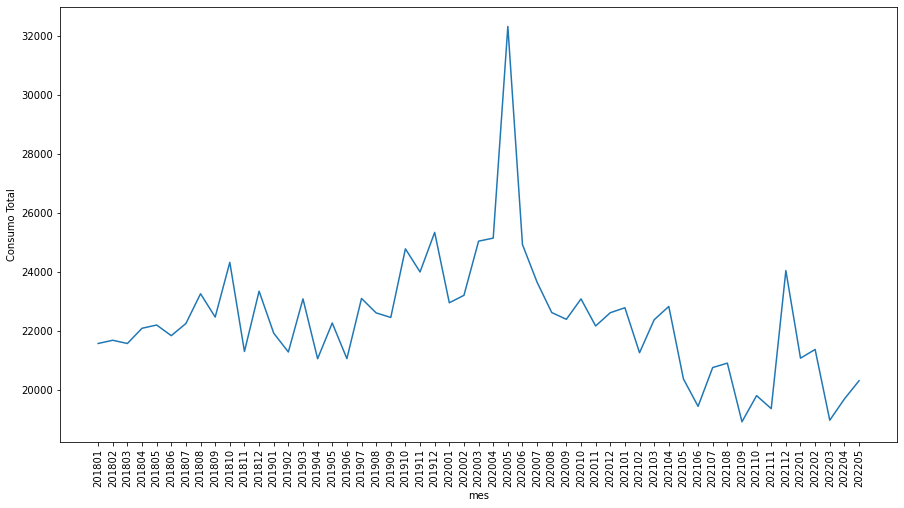

In [22]:
plot_target_behavior(df,'consumoacumuladodomes_soma')

## Teste de estacionaridade

In [23]:
adf_test(df['consumoacumuladodomes_soma'])

Resultado do Teste Dickey-Fuller:
Teste                     -2.410381
Valor p                    0.138828
# de lags                  1.000000
# de observações          51.000000
Valores Críticos (1%)     -3.565624
Valores Críticos (5%)     -2.920142
Valores Críticos (10%)    -2.598015
dtype: float64


## Média Móvel

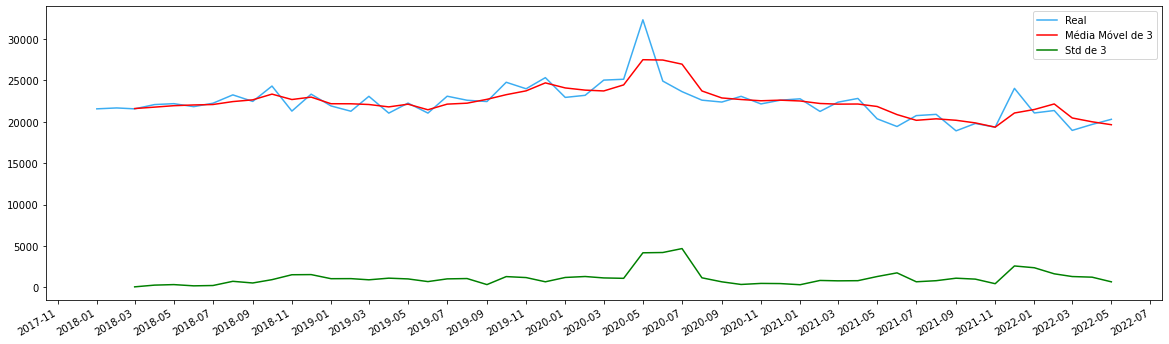

In [24]:
plot_moving_average(df,'consumoacumuladodomes_soma', 3)

## Decomposição da série

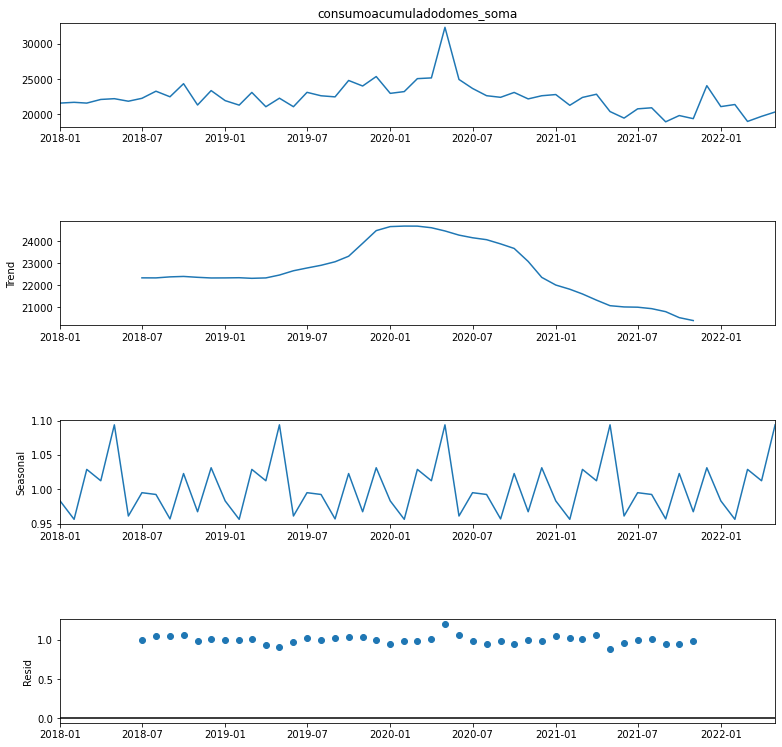

In [25]:
decompose_data = serie_decompose(df,'consumoacumuladodomes_soma')

### Sazonalidade da série

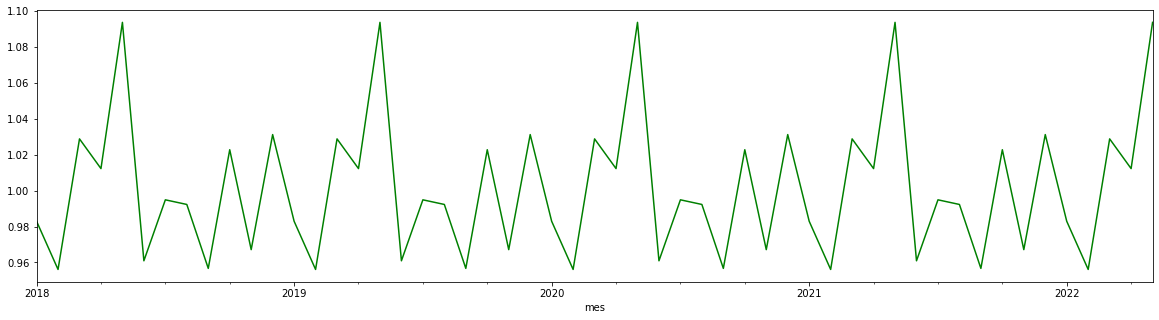

In [26]:
seasonality = plot_seasonality(decompose_data)

In [27]:
seasonality

mes
2018-01-01    0.982964
2018-02-01    0.956128
2018-03-01    1.028830
2018-04-01    1.012290
2018-05-01    1.093726
2018-06-01    0.960945
2018-07-01    0.994901
2018-08-01    0.992319
2018-09-01    0.956716
2018-10-01    1.022794
2018-11-01    0.967160
2018-12-01    1.031227
2019-01-01    0.982964
2019-02-01    0.956128
2019-03-01    1.028830
2019-04-01    1.012290
2019-05-01    1.093726
2019-06-01    0.960945
2019-07-01    0.994901
2019-08-01    0.992319
2019-09-01    0.956716
2019-10-01    1.022794
2019-11-01    0.967160
2019-12-01    1.031227
2020-01-01    0.982964
2020-02-01    0.956128
2020-03-01    1.028830
2020-04-01    1.012290
2020-05-01    1.093726
2020-06-01    0.960945
2020-07-01    0.994901
2020-08-01    0.992319
2020-09-01    0.956716
2020-10-01    1.022794
2020-11-01    0.967160
2020-12-01    1.031227
2021-01-01    0.982964
2021-02-01    0.956128
2021-03-01    1.028830
2021-04-01    1.012290
2021-05-01    1.093726
2021-06-01    0.960945
2021-07-01    0.994901
2021-08

## Gráfico de diferenciações, autocorrelações e autocorrelações parciais

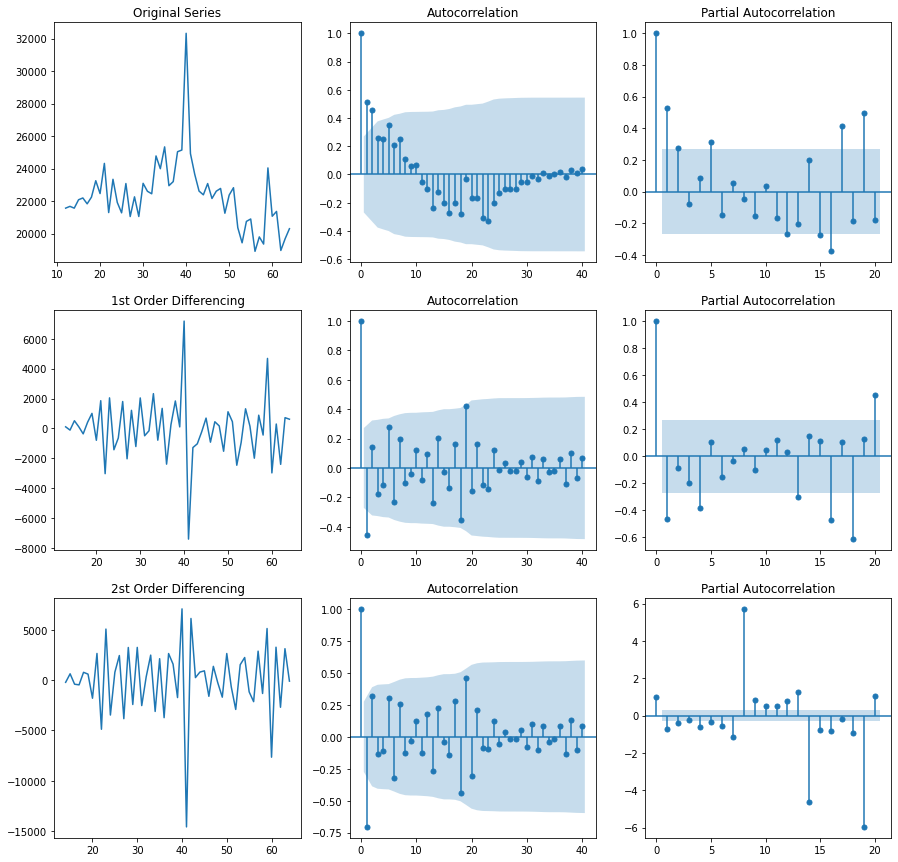

In [28]:
plot_diff_acp_pacf(df, 'consumoacumuladodomes_soma')

## Diferenciação de primeira ordem e teste de estacionariedade na série diferenciada

Resultado do Teste Dickey-Fuller:
Teste                    -6.012716e+00
Valor p                   1.559615e-07
# de lags                 3.000000e+00
# de observações          4.800000e+01
Valores Críticos (1%)    -3.574589e+00
Valores Críticos (5%)    -2.923954e+00
Valores Críticos (10%)   -2.600039e+00
dtype: float64
None


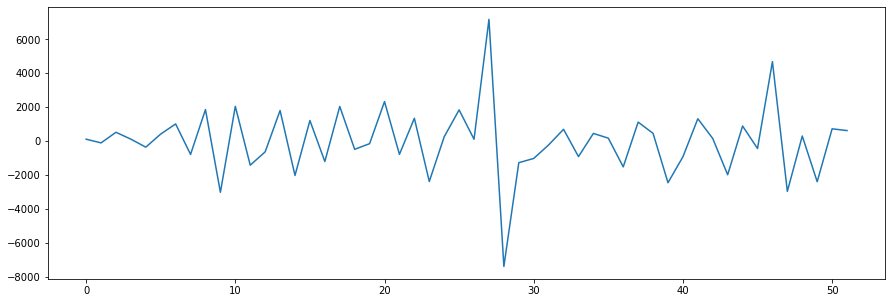

In [29]:
df_diff = serie_differentiation(df,'consumoacumuladodomes_soma')

In [30]:
df_diff

array([  109.,  -110.,   517.,   110.,  -361.,   413.,  1009.,  -791.,
        1857., -3025.,  2046., -1424.,  -639.,  1802., -2030.,  1212.,
       -1209.,  2041.,  -489.,  -155.,  2328.,  -785.,  1343., -2388.,
         252.,  1838.,   104.,  7182., -7402., -1278., -1028.,  -229.,
         692.,  -918.,   449.,   169., -1525.,  1117.,   453., -2460.,
        -930.,  1316.,   150., -1990.,   887.,  -441.,  4685., -2973.,
         296., -2401.,   721.,   618.])

## Autocorreação por número de meses

In [31]:
autocorrelation_lag(df, 'consumoacumuladodomes_soma')

Um mês:  0.521623620250112
Três meses:  0.275038928830511
Seis meses:  0.2244809936861798
Nove meses:  0.062127580088688746
Doze meses:  -0.12847211499552205


## Divisão em treino e teste

In [32]:
date_split = dt.datetime(2022, 1, 1)
date_end = dt.datetime(2022, 12, 1)

xtrain, xtest, interval_start, interval_end, dataset = train_test_split_data(df, 'consumoacumuladodomes_soma', '2022-06-01', 7, 'M', date_split, date_end, False)

Train interval:  2018-01-01  até  2021-12-01
Test interval:  2022-01-01  até  2022-12-01
Test interval:  48  até  59


## Execução do auto arima

In [33]:
stepwise_model, summary = automatic_arima(xtrain, start_p=1, start_q=1,max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, n_jobs = 1)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=659.287, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=655.251, Time=0.09 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=658.820, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=656.845, Time=0.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=655.294, Time=0.24 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=660.549, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=657.382, Time=0.05 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=657.032, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=659.895, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=659.010, Time=0.17 sec
 ARIMA(0,1,1)(2,1,0)[12]      

## Predição e validação do modelo

In [34]:
xtest['pred'] = stepwise_model.predict(n_periods=12)

In [35]:
y_true = xtest[~xtest['consumoacumuladodomes_soma'].isna()]['consumoacumuladodomes_soma'].values
y_pred = xtest[~xtest['consumoacumuladodomes_soma'].isna()]['pred'].values

validation_metrics(y_true, y_pred)

MAPE: 23.42, RMSE: 4884.40, MAE: 4684.03


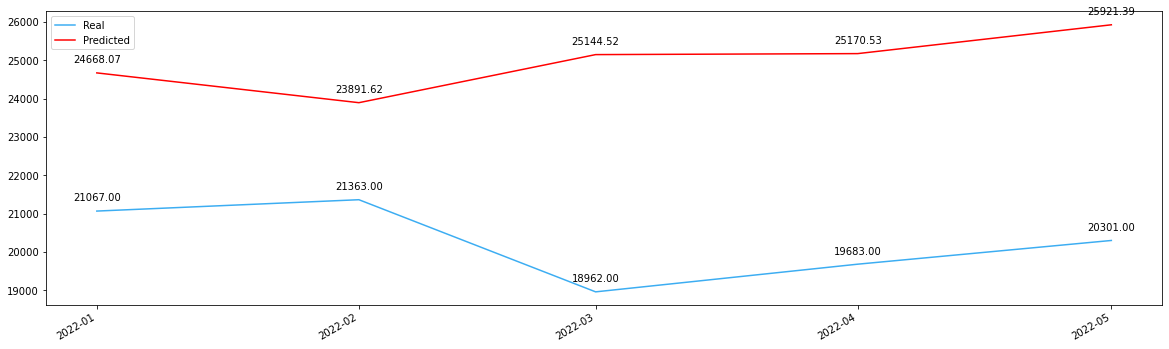

In [36]:
plot_predict_x_real(xtest, 'consumoacumuladodomes_soma', 'pred')

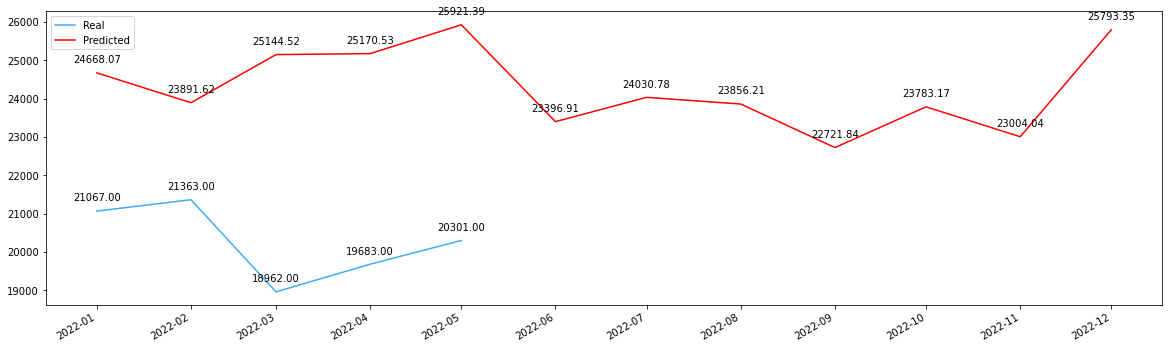

In [37]:
plot_year_behavior(xtest, 'consumoacumuladodomes_soma', 'pred')

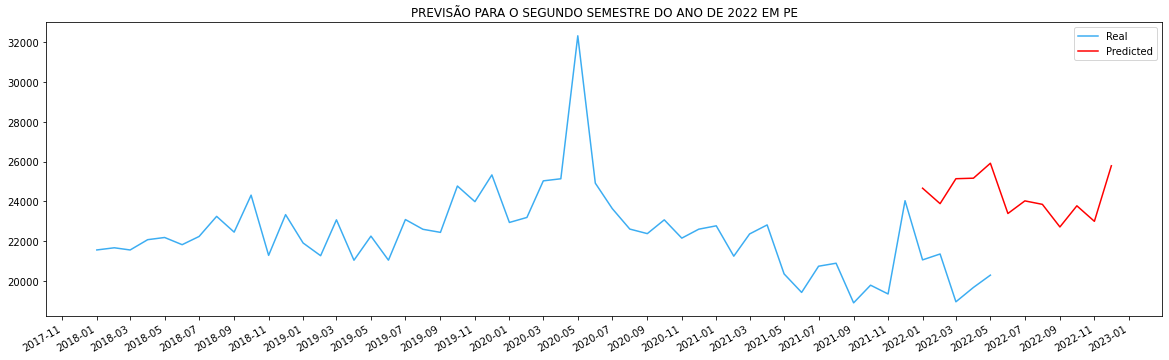

In [38]:
plot_serie_behavior(df, xtest, interval_start, 'consumoacumuladodomes_soma', 'pred', "PREVISÃO PARA O SEGUNDO SEMESTRE DO ANO DE 2022 EM PE")

## Execução do Sarimax com parâmetros pré-definidos

In [39]:
sarimax, df_test = sarimax_algorithm(xtrain, xtest, 'consumoacumuladodomes_soma', interval_start, interval_end, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), normalization= True)

## Predição e validação do modelo

In [40]:
df_test

,consumoacumuladodomes_soma,pred
mes,,
2022-01-01,21067.0,21353.377678
2022-02-01,21363.0,20869.560651
2022-03-01,18962.0,22010.540172
2022-04-01,19683.0,21453.126764
2022-05-01,20301.0,24312.281417
2022-06-01,NaN,21190.731150
2022-07-01,NaN,21604.876458
2022-08-01,NaN,21361.834631
2022-09-01,NaN,20952.681293


In [41]:
y_true = df_test[~df_test['consumoacumuladodomes_soma'].isna()]['consumoacumuladodomes_soma'].values
y_pred = df_test[~df_test['consumoacumuladodomes_soma'].isna()]['pred'].values

validation_metrics(y_true, y_pred)

MAPE: 9.70, RMSE: 2401.78, MAE: 1921.95


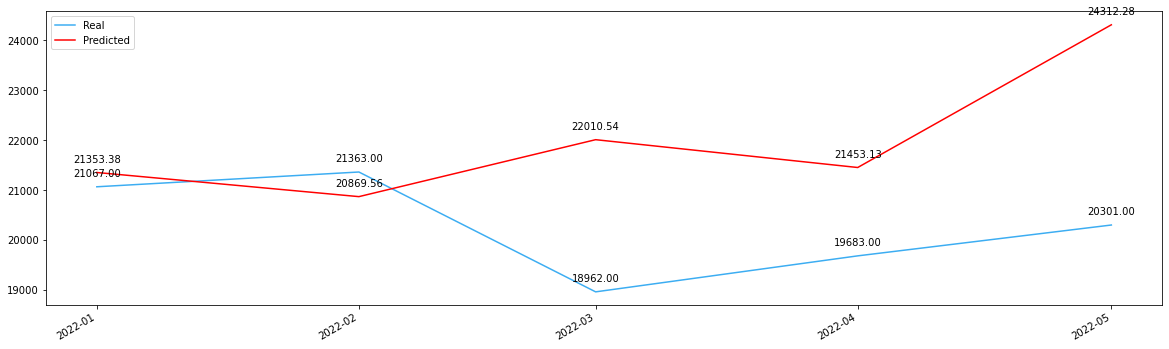

In [42]:
plot_predict_x_real(df_test, 'consumoacumuladodomes_soma', 'pred')

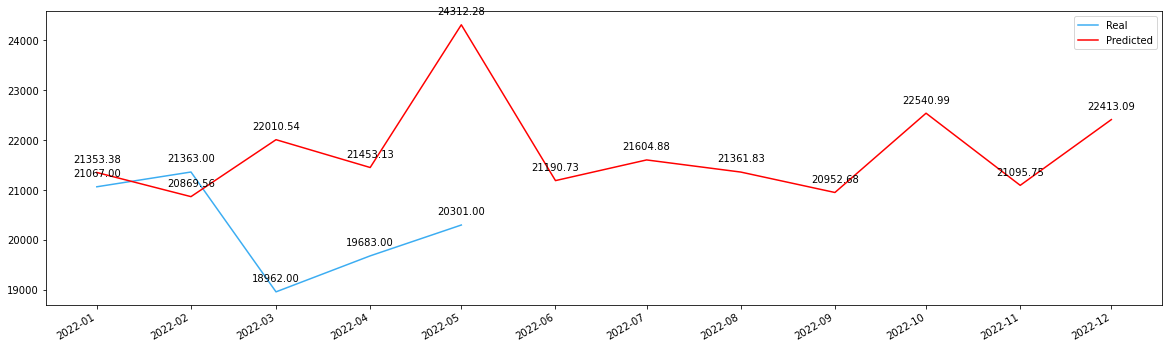

In [43]:
plot_year_behavior(df_test, 'consumoacumuladodomes_soma', 'pred')

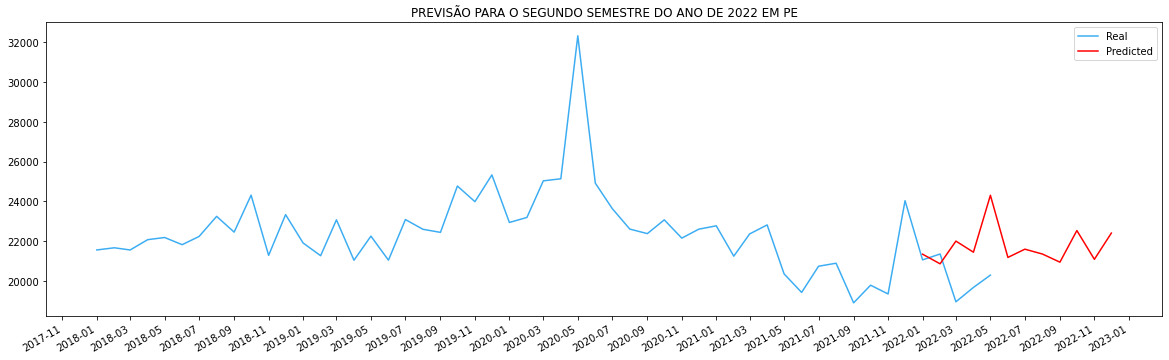

In [44]:
plot_serie_behavior(df, df_test, interval_start, 'consumoacumuladodomes_soma', 'pred', "PREVISÃO PARA O SEGUNDO SEMESTRE DO ANO DE 2022 EM PE")

In [45]:
y_pred - y_true

array([ 286.3776782 , -493.439349  , 3048.5401723 , 1770.1267645 ,
       4011.28141683])

## Execução do sarimax, a partir dos parâmetros fornecidos pelo auto arima

In [46]:
stepwise_model, summary = automatic_arima(xtrain, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=False, n_jobs = 1, normalization=True, target = 'consumoacumuladodomes_soma')

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-6.003, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-13.679, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-20.775, Time=0.23 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=-18.775, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-7.450, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-20.241, Time=0.34 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-17.094, Time=0.20 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-

In [47]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                  15.063
Date:                             Mon, 26 Sep 2022   AIC                            -22.125
Time:                                     16:58:51   BIC                            -15.904
Sample:                                          0   HQIC                           -19.977
                                              - 48                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2890      0.121     -2.390      0.017      -0.526      -0.052
ar.S.L12      -1.0078      0.146     -6.883      0.000      -1.295      -0.721
ar.S.L24      -0.7270      0.181     -4.015      0.000      -1.082      -0.372
sigma2         0.0128      0.007      1.886      0.059      -0.000       0.026
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.51
Prob(Q):                              0.86   Prob(JB):                         0.02
Heteroskedasticity (H):               5.04   Skew:                             0.70
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
sarimax, df_test = sarimax_algorithm(xtrain, xtest, 'consumoacumuladodomes_soma', interval_start, interval_end, order=(0, 1, 1), seasonal_order=(0, 1, 0, 12), normalization= True)

## Predição e validação do modelo

In [49]:
df_test

,consumoacumuladodomes_soma,pred
mes,,
2022-01-01,21067.0,22340.271514
2022-02-01,21363.0,20815.271514
2022-03-01,18962.0,21932.271514
2022-04-01,19683.0,22385.271514
2022-05-01,20301.0,19925.271514
2022-06-01,NaN,18995.271514
2022-07-01,NaN,20311.271514
2022-08-01,NaN,20461.271514
2022-09-01,NaN,18471.271514


In [50]:
y_true = df_test[~df_test['consumoacumuladodomes_soma'].isna()]['consumoacumuladodomes_soma'].values
y_pred = df_test[~df_test['consumoacumuladodomes_soma'].isna()]['pred'].values

validation_metrics(y_true, y_pred)

MAPE: 7.97, RMSE: 1907.21, MAE: 1573.85


## Gráfico do real x predito

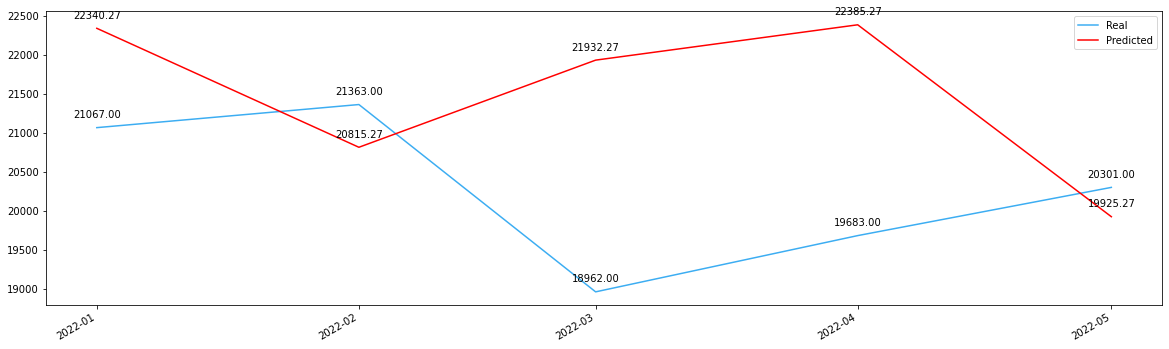

In [51]:
plot_predict_x_real(df_test, 'consumoacumuladodomes_soma', 'pred')

## Gráfico do comportamento anual do real x predito

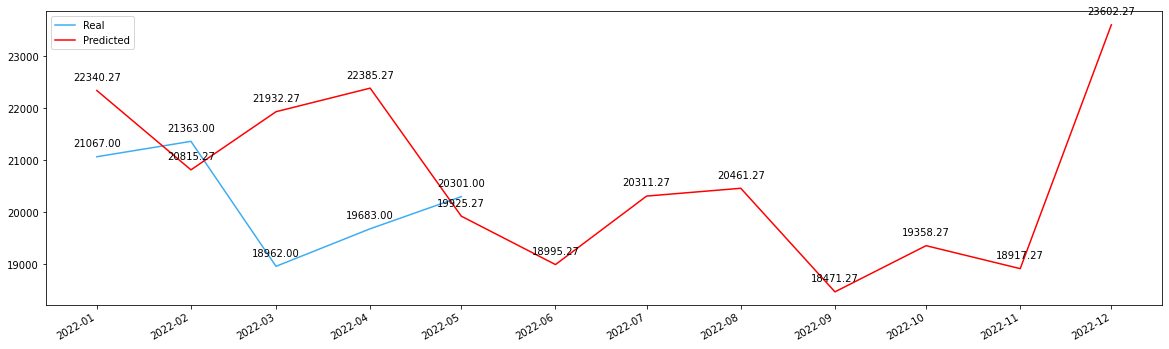

In [52]:
plot_year_behavior(df_test, 'consumoacumuladodomes_soma', 'pred')

## Gráfico do comportamento da série real x predito

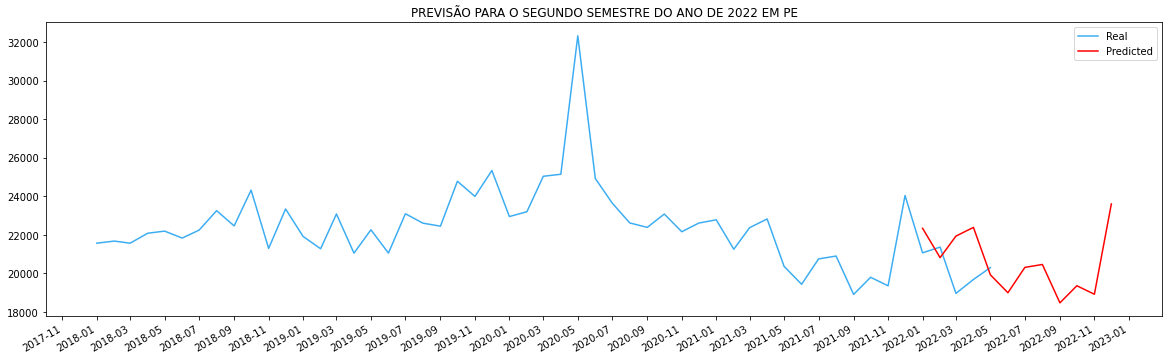

In [53]:
plot_serie_behavior(df, df_test, interval_start, 'consumoacumuladodomes_soma', 'pred', "PREVISÃO PARA O SEGUNDO SEMESTRE DO ANO DE 2022 EM PE")